In [12]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.linalg as sl

## Part1：least squares

In [3]:
sales=pd.read_csv(r'E:\学习资料_summary\八斗2023AI清华班\【7】sift & opencv算法\代码\最小二乘法\train_data.csv',sep='\s*,\s*',engine='python')  #读取CSV

In [4]:
sales

,X,Y
0,1,6
1,2,5
2,3,7
3,4,10


In [5]:
X=sales['X'].values
Y=sales['Y'].values

In [6]:
s1 = 0     
s2 = 0
s3 = 0     
s4 = 0
n = len(sales)

In [7]:
for i in range(n):
    s1 = s1 + X[i]*Y[i]
    s2 = s2 + X[i]
    s3 = s3 + Y[i]
    s4 = s4 + X[i]*X[i]

In [8]:
k = (s2*s3-n*s1)/(s2*s2-s4*n)
b = (s3 - k*s2)/n
print("Coeff: {} Intercept: {}".format(k, b))

Coeff: 1.4 Intercept: 3.5


## Part2:Ransac

In [31]:
def random_partition(n, n_data):
    """return n random rows of data and the other len(data) - n rows"""
    all_idxs = np.arange(n_data) #获取n_data下标索引
    np.random.shuffle(all_idxs) #打乱下标索引
    idxs1 = all_idxs[:n]
    idxs2 = all_idxs[n:]
    return idxs1, idxs2

In [36]:
def ransac(data, model, n, k, t, d, debug = False, return_all = False):
    """
    输入:
        data - 样本点
        model - 假设模型:事先自己确定
        n - 生成模型所需的最少样本点
        k - 最大迭代次数
        t - 阈值:作为判断点满足模型的条件
        d - 拟合较好时,需要的样本点最少的个数,当做阈值看待
    输出:
        bestfit - 最优拟合解（返回nil,如果未找到）
    """
    iterations = 0
    bestfit = None
    besterr = np.inf
    best_inlier_idxs = None
    while iterations < k:
        maybe_idxs, test_idxs = random_partition(n, data.shape[0])
        print ('test_idxs = ', test_idxs)
        maybe_inliers = data[maybe_idxs, :] #获取size(maybe_idxs)行数据(Xi,Yi)
        test_points = data[test_idxs] #若干行(Xi,Yi)数据点
        maybemodel = model.fit(maybe_inliers) #拟合模型
        test_err = model.get_error(test_points, maybemodel) #计算误差:平方和最小
        print('test_err = ', test_err <t)
        also_idxs = test_idxs[test_err < t]
        print ('also_idxs = ', also_idxs)
        also_inliers = data[also_idxs,:]
        if debug:
            print ('test_err.min()',test_err.min())
            print ('test_err.max()',test_err.max())
            print ('numpy.mean(test_err)',numpy.mean(test_err))
            print ('iteration %d:len(alsoinliers) = %d' %(iterations, len(also_inliers)) )
        print('d = ', d)
        if (len(also_inliers) > d):
            betterdata = np.concatenate( (maybe_inliers, also_inliers) ) #样本连接
            bettermodel = model.fit(betterdata)
            better_errs = model.get_error(betterdata, bettermodel)
            thiserr = np.mean(better_errs) #平均误差作为新的误差
            if thiserr < besterr:
                bestfit = bettermodel
                besterr = thiserr
                best_inlier_idxs = np.concatenate( (maybe_idxs, also_idxs) ) #更新局内点,将新点加入
        iterations += 1
    if bestfit is None:
        raise ValueError("did't meet fit acceptance criteria")
    if return_all:
        return bestfit,{'inliers':best_inlier_idxs}
    else:
        return bestfit

In [29]:
class LinearLeastSquareModel:
    #最小二乘求线性解,用于RANSAC的输入模型    
    def __init__(self, input_columns, output_columns, debug = False):
        self.input_columns = input_columns
        self.output_columns = output_columns
        self.debug = debug
    
    def fit(self, data):
		#np.vstack按垂直方向（行顺序）堆叠数组构成一个新的数组
        A = np.vstack( [data[:,i] for i in self.input_columns] ).T #第一列Xi-->行Xi
        B = np.vstack( [data[:,i] for i in self.output_columns] ).T #第二列Yi-->行Yi
        x, resids, rank, s = sl.lstsq(A, B) #residues:残差和
        return x #返回最小平方和向量   
 
    def get_error(self, data, model):
        A = np.vstack( [data[:,i] for i in self.input_columns] ).T #第一列Xi-->行Xi
        B = np.vstack( [data[:,i] for i in self.output_columns] ).T #第二列Yi-->行Yi
        B_fit = sp.dot(A, model) #计算的y值,B_fit = model.k*A + model.b
        err_per_point = np.sum( (B - B_fit) ** 2, axis = 1 ) #sum squared error per row
        return err_per_point

In [13]:
n_samples = 500 #样本个数
n_inputs = 1 #输入变量个数
n_outputs = 1 #输出变量个数
A_exact = 20 * np.random.random((n_samples, n_inputs))#随机生成0-20之间的500个数据:行向量
perfect_fit = 60 * np.random.normal(size = (n_inputs, n_outputs)) #随机线性度，即随机生成一个斜率
B_exact = sp.dot(A_exact, perfect_fit) # y = x * k

C:\ProgramData\Anaconda3\envs\deeplearning_gpu\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: scipy.dot is deprecated and will be removed in SciPy 2.0.0, use numpy.dot instead
  


In [16]:
#加入高斯噪声,最小二乘能很好的处理
A_noisy = A_exact + np.random.normal( size = A_exact.shape ) #500 * 1行向量,代表Xi
B_noisy = B_exact + np.random.normal( size = B_exact.shape ) #500 * 1行向量,代表Yi

In [19]:
#添加"局外点"，just to make it become a hard data to least squares
n_outliers = 100
all_idxs = np.arange( A_noisy.shape[0] ) # A_noisy.shape[0] = 500
np.random.shuffle(all_idxs) #将all_idxs打乱
outlier_idxs = all_idxs[:n_outliers] #100个0-500的随机局外点
A_noisy[outlier_idxs] = 20 * np.random.random( (n_outliers, n_inputs) )
B_noisy[outlier_idxs] = 50 * np.random.normal( size = (n_outliers, n_outputs))

In [30]:
all_data = np.hstack( (A_noisy, B_noisy) )
input_columns = range(n_inputs)
output_columns = [n_inputs + i for i in range(n_outputs)]
debug = False
#类的实例化:用最小二乘生成已知模型
model = LinearLeastSquareModel(input_columns, output_columns, debug = debug) 
linear_fit,resids,rank,s = sp.linalg.lstsq(all_data[:,input_columns], 
                                           all_data[:,output_columns])

In [37]:
#run RANSAC 算法
ransac_fit, ransac_data = ransac(all_data, model, 50, 1000, 7e3, 300, 
                                 debug = debug, return_all = True)

test_idxs =  [292 462 122 322 475 241 264 329 131 313 119   5 494  26 405 497 274 242
 385 243  36  89  23  45  50 258 117 342 404 423 256 253 185 452  30 171
 458 364 126 430 320   2 239 244 129 359 429 350 150 324 286 234 229  90
 302 265 467 219 267 282 204  34 396   6 434   9 427  27  83 489 378  74
  31 301  39 442 416 354 182 164 148 285  43 209 107 259 101 474 454  61
 492  57 484  44 218 127 249 384 128 263 428  14 476 422 111 432 236 177
 208 250 464  56 387 438 246 166 290 459 406 332 294 347 109 420 463 486
 371 252 466  28 330 300 272 266 477  13 163 448 262 288 240 360 417 147
  73 306 305 220 172 181 472 278 194 391 104 341 377  15 143 108 373 146
  94 206 470 157 307 202 365 493 400  93   4 426  86 213 471 277  53 441
 392 161 102 175 327 370 207 357 395  33 138 308  64 362 473 120 228 199
 374  24 402 223  85 421 358 291 212  78 144 340 318 397 380 437 279 154
 339  52 173 184 295  49 170 123 176 183 106 376 137 499 297 151 280 383
 478 124 275 435 116 419 457 114 491  

C:\ProgramData\Anaconda3\envs\deeplearning_gpu\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: scipy.dot is deprecated and will be removed in SciPy 2.0.0, use numpy.dot instead


[209  40 153 338 431 416 260 109 103 418 266 367 265  51 267 228  65  59
 340 497 306 314 346 219 316 304 466 252 123 119 296  58 100 459 110 139
 159  23   0 363  14 393 164 410 430 174 241 154 262 215 396  47 140 236
 101 473 349 196 259  20  52 230 321 199 172 452 105 234 201  91  98 387
 243 307 225 274  46 132 377  88 130 212  99   3 404  24 127  81 145 411
 247 335 373 184 350 281 398 435 351 498 170 375 264  17 320 256 414 412
   4 429 333  70 376 193 361 242 258 495 444 261  89 305 344 138 368 124
 343 208 250 347 200 167  77 239  97 275 468 324  15 327 263 443 419 420
 438 189 244  79 273   2 415  36  86 423 257 469 436 406 448 401 428  67
 318  26 289 422 383  22 315 147 389 248 472 222 146 204 455 339 313 451
  57 298 332 312  62 102 355 218 461 301 185 206  25 409  83 141 458 283
 235 107 155  85 353 374  10 425 492 317   6 385 134 491 294   1 356 488
 240 372 268 207  37 424  41  18   5 453 486 460 364 197  33 173 345 291
 190 144 191 433 399 150 133 359 470 114 483 176 16

d =  300
test_idxs =  [284 218 434  76  39 340 259   8 208  31  67 111 494  21 318 104 147 225
 382 172 223  44 439 404  60 215 217 468 177 376 199 261 235 242 360 130
 408 249 355 115 269 448 290 129 344 452 176 495  29 302 163 229 455  63
 328 179 357 178 247  22 456 356 239  62 332 414 379 197 366 165 386 480
 306 372 329 300 423  79 426 445 484 421  84 490 234 463 466 362  91 331
  12 358 122  90 442  46 206 100 389 418  99  13 214 119  47 342 333   7
  75 188 153 305 144 427 271 395 156 213 140 164 220  33  80 264  54 191
 200 170 352 458 459  36 209  49 244  98  93  71 116  23 347 413 336 368
 397  26 238 440 469 128 446 422 203 485 145 221  81 171 105 391  87 464
   4 193 470 243 161  57 420  48 451 410 186 283 173 190  73 486 251 462
 134 363  16 383 174 286 325 497 338 138 273 424   2 351  92 449  15 114
 425 393 390 330 258 419 474 309 195 479  18 142 316 110 339 109 227 198
  28  52 435 353 465 461 166 343 106 299  50 401 112  10 345 157 417  69
  37 133  65 196 399 102 268 

d =  300
test_idxs =  [249 288 137 433  19   0 144  76  77 465 414 495 133  38  40 248 164 347
  72  59 131  71 441 236  39 280 270 401 241 170  86 344 129 188 267 122
 134 481 479 128 226 258 155  55 475  36 369   1   8 221 415 209 322 486
 152 420 406 335  82 343 337 308 499 313  75 206 388 384 171  58 387 200
 264 428 466 117  85 150 309 423   2 291 246 402 130 289 326 193 472 493
 419 279  78 448 294 126 178  60  13 310  95 245 370 404 391 361 407 135
 438   9 213 224 208 471 220 121 474 100 136 364 230 197  23 453 110 265
 196 498 161 349 233 154 360 234 442 223  89 314 173  67 311 132  73 332
 185 217 187  30 452 345 212 397  66 416  31 179 102 487 105 275 355 405
 214 367  14 162 381 273 464  65 395 268 409  11 153 373 103 113 293  88
 192 271 312 327 169 138  61 477 325 490 494 497 292 253 429 378 403 480
 304  79 427 434 194   4 183  98 159 435 375 483  22 400 350 202  62 320
 250 181 124 151 198 118 244 176 156 157 492  87 353  41 101  56 290 376
  63 140 354 346  27 218 394 

test_err =  [False False  True False  True  True False False  True False  True  True
  True  True  True False False  True False  True  True False  True False
 False False  True  True  True  True False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True  True  True
 False  True  True False  True  True  True  True False  True  True False
  True  True  True  True  True  True  True False  True  True  True  True
 False  True False  True  True  True False False False False  True  True
 False  True  True  True  True  True False False False False False  True
  True  True  True  True  True False  True  True False  True False False
  True  True False  True  True  True  True  True  True  True  True  True
  True False False  True  True False  True False  True  True False  True
  True  True  True False  True  True  True  True  True  True False  True
 False  True  True False False  True  True  True  True False  True  True
  True False  True  True  True  True Fa

d =  300
test_idxs =  [489  36 322 330 237  42 276  33 397 490 463 109 270 142 286 425 233 499
  18  45 216 126 227 486 131 265 376  58 380 242 378 460 288 263  84 481
 363 422 158 474  95 169 252 118 255 341 300 116  54 333 183  20  19 117
 417  65 402  50 381 336 101 449 390  82 494  12  29 356  61 354 229 133
 327 221 399 331 332  16  74 141 283  51 347 454 382  48 225  41 433 110
 365 348 139 371 287 256   2  87 401  34 222 360 166  47 202 294 445   7
 153 123 192 257 161 370 296 106 310 258  64 478 431 111  27 392 194  93
 103 279 462 168  23 329  59 113 247 369  86 374 467  31  81 102  43 420
 262 190 205 208   8 447  52 124 308 180  67 328 251 170 437 497 176  73
 304 320 151 455  83 306 280 231  22 159 114 127 267 145 368 108 211 393
 359 120 409 187 115 323 217 107  70 173 171 415 188 413 319 485 212 438
 149 163 325 443 472  28  10 456 411  14 184 388 282  55  69  79 239 105
  46 218 466 311 266  99 326 189 408  94 140 424 406  24 410 405  75 241
  37 450 343  30  76 281 253 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



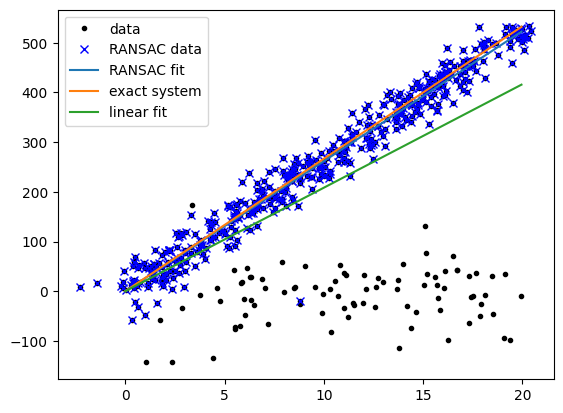

In [39]:
if 1:
    import pylab
 
    sort_idxs = np.argsort(A_exact[:,0])
    A_col0_sorted = A_exact[sort_idxs] #秩为2的数组
 
    if 1:
        pylab.plot( A_noisy[:,0], B_noisy[:,0], 'k.', label = 'data' ) #散点图
        pylab.plot( A_noisy[ransac_data['inliers'], 0], B_noisy[ransac_data['inliers'], 0], 'bx', label = "RANSAC data" )
    else:
        pylab.plot( A_noisy[non_outlier_idxs,0], B_noisy[non_outlier_idxs,0], 'k.', label='noisy data' )
        pylab.plot( A_noisy[outlier_idxs,0], B_noisy[outlier_idxs,0], 'r.', label='outlier data' )
 
    pylab.plot( A_col0_sorted[:,0],
                np.dot(A_col0_sorted,ransac_fit)[:,0],
                label='RANSAC fit' )
    pylab.plot( A_col0_sorted[:,0],
                np.dot(A_col0_sorted,perfect_fit)[:,0],
                label='exact system' )
    pylab.plot( A_col0_sorted[:,0],
                np.dot(A_col0_sorted,linear_fit)[:,0],
                label='linear fit' )
    pylab.legend()
    pylab.show()